# Problem setting: Sine Wave Prediction.

This jupyter notebook demonstrates the function of **Attention Encoder/Decoder based on LSTM**.

In this demonstration, the training dataset is generated as follows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pydbm")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)


In [3]:
def generate_sin(amp=0.5, sampling_freq=8000, freq=440, sec=5, extract_n=100):
    sin_list = []
    for n in np.arange(sampling_freq * sec):
        sin = amp * np.sin(2.0 * np.pi * freq * n / sampling_freq)
        sin_list.append(sin)
        if len(sin_list) > extract_n:
            break
    return np.array(sin_list[:extract_n])


In [4]:
generate_sin(freq=200).shape

(100,)

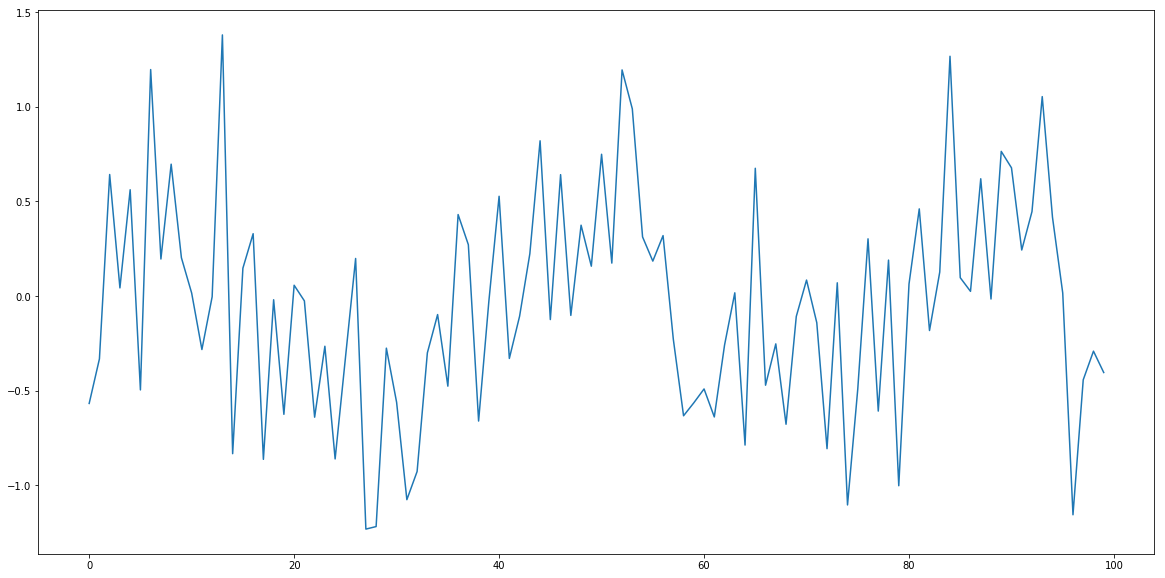

In [5]:
fig = plt.figure(figsize=(20, 10))
plt.plot(generate_sin(freq=200) + np.random.normal(loc=0.0, scale=0.5, size=100))
plt.show()

In [6]:
# The number of sampled data.
sample_n = 1000
# The length of one cycle.
cycle_len = 20
# The number of features.
feature_n = 20

# The list of observed data points.
observed_arr_list = []
# The list of objective data.
target_arr_list = []

label_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
test_size = 0.3

for i in range(sample_n):
    f_list = []
    t_list = []
    label_n = np.random.randint(low=0, high=len(label_list))

    for j in range(feature_n):
        sin_arr = generate_sin(freq=int(label_list[label_n]), extract_n=cycle_len)
        noise_arr = np.random.normal(loc=0.0, scale=1.5, size=cycle_len)
        sin_arr += noise_arr
        f_arr = sin_arr[:int(sin_arr.shape[0] * (1 - test_size))]
        t_arr = sin_arr[int(sin_arr.shape[0] * (1 - test_size)):]
        f_list.append(f_arr)
        t_list.append(t_arr)

    observed_arr_list.append(f_list)
    target_arr_list.append(t_list)

observed_arr = np.array(observed_arr_list)

observed_arr.shape

(1000, 20, 14)

All Sine waves have been added randomly generated gussain signal noise.

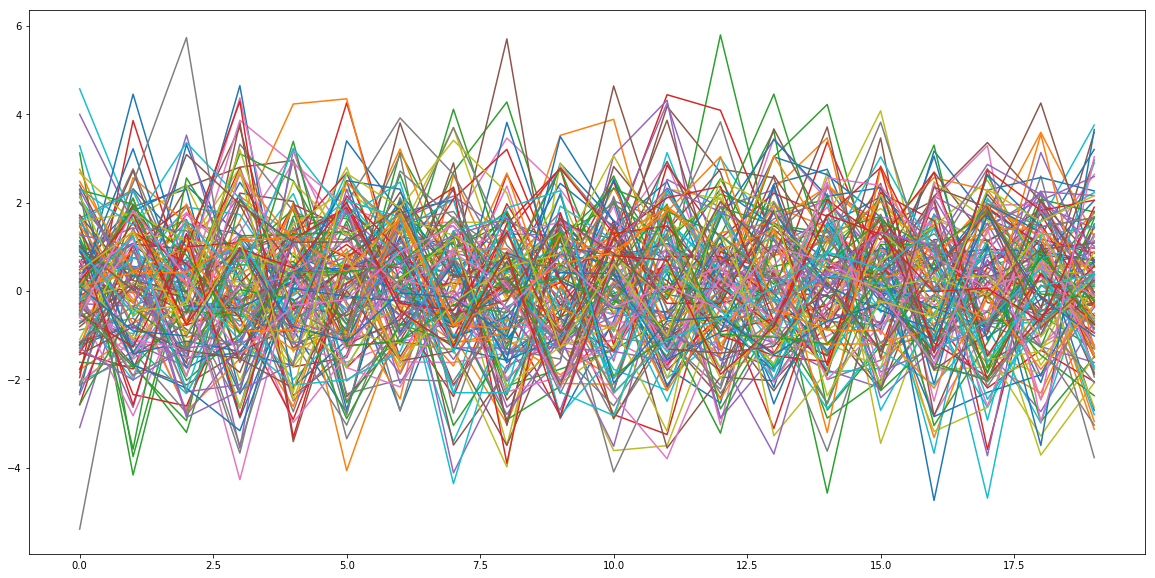

In [7]:
fig = plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(observed_arr[i])
plt.show();plt.close()

## Problem solution: Encoder/Decoder based on LSTM.

In [8]:
# LSTM Graph which is-a `Synapse`.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph
# Polymorphism.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as EncoderGraph
from pydbm.synapse.recurrenttemporalgraph.lstmgraph.attention_lstm_graph import AttentionLSTMGraph as DecoderGraph

# Loss function.
from pydbm.loss.mean_squared_error import MeanSquaredError
# SGD as a Loss function.
from pydbm.optimization.optparams.sgd import SGD
# Adam as a Loss function.
from pydbm.optimization.optparams.adam import Adam as EncoderAdam
from pydbm.optimization.optparams.adam import Adam as DecoderAdam
# Verification.
from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation
# LSTM model.
from pydbm.rnn.lstm_model import LSTMModel
# Polymorphism.
from pydbm.rnn.lstm_model import LSTMModel as Encoder
from pydbm.rnn.lstmmodel.attention_lstm_model import AttentionLSTMModel as Decoder
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# Identity Function as activation function.
from pydbm.activation.identity_function import IdentityFunction
# Encoder/Decoder
from pydbm.rnn.encoder_decoder_controller import EncoderDecoderController

In [9]:
# Init.
encoder_graph = EncoderGraph()

# Activation function in LSTM.
encoder_graph.observed_activating_function = TanhFunction()
encoder_graph.input_gate_activating_function = LogisticFunction()
encoder_graph.forget_gate_activating_function = LogisticFunction()
encoder_graph.output_gate_activating_function = LogisticFunction()
encoder_graph.hidden_activating_function = TanhFunction()
encoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
encoder_graph.create_rnn_cells(
    input_neuron_count=observed_arr.shape[-1],
    hidden_neuron_count=200,
    output_neuron_count=1
)

In [10]:
# Init.
decoder_graph = DecoderGraph()

# Activation function in LSTM.
decoder_graph.observed_activating_function = TanhFunction()
decoder_graph.input_gate_activating_function = LogisticFunction()
decoder_graph.forget_gate_activating_function = LogisticFunction()
decoder_graph.output_gate_activating_function = LogisticFunction()
decoder_graph.hidden_activating_function = LogisticFunction()
decoder_graph.output_activating_function = IdentityFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
decoder_graph.create_rnn_cells(
    input_neuron_count=200,
    hidden_neuron_count=200,
    output_neuron_count=observed_arr.shape[-1]
)

In [11]:
encoder_opt_params = EncoderAdam()
encoder_opt_params.weight_limit = 0.5
encoder_opt_params.dropout_rate = 0.5

encoder = Encoder(
    # Delegate `graph` to `LSTMModel`.
    graph=encoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=cycle_len,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=encoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [12]:
decoder_opt_params = DecoderAdam()
decoder_opt_params.weight_limit = 0.5
decoder_opt_params.dropout_rate = 0.5

decoder = Decoder(
    # Delegate `graph` to `LSTMModel`.
    graph=decoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=100,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    seq_len=observed_arr.shape[1],
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=cycle_len,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=decoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [13]:
encoder_decoder_controller = EncoderDecoderController(
    encoder=encoder,
    decoder=decoder,
    epochs=300,
    batch_size=20,
    learning_rate=1e-08,
    learning_attenuate_rate=0.1,
    attenuate_epoch=50,
    test_size_rate=0.3,
    computable_loss=MeanSquaredError(),
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [14]:
# Learning.
encoder_decoder_controller.learn(observed_arr, observed_arr)

Best params are updated.
Epoch: 1
Loss: 
Training: 0.008525189834688928 Test: 0.007447817412316537
Epoch: 2
Loss: 
Training: 0.008428222124752418 Test: 0.007254066929125105
Epoch: 3
Loss: 
Training: 0.008301769015883335 Test: 0.007344467207954938
Epoch: 4
Loss: 
Training: 0.008637917422178842 Test: 0.007366132515027617
Best params are updated.
Epoch: 5
Loss: 
Training: 0.008622430292435252 Test: 0.006953832951848358
Epoch: 6
Loss: 
Training: 0.008782532270199527 Test: 0.0072328717879565725
Epoch: 7
Loss: 
Training: 0.00842573264264242 Test: 0.00692107468478914
Epoch: 8
Loss: 
Training: 0.00847149022077114 Test: 0.00703426220624681
Epoch: 9
Loss: 
Training: 0.008467777448320193 Test: 0.007219726737255149
Epoch: 10
Loss: 
Training: 0.008287382637086857 Test: 0.007190537191108728
Epoch: 11
Loss: 
Training: 0.008808823050549374 Test: 0.006974316600275415
Rolling mean of Loss (Window is 10): 
Training: 0.00849504439089589 Test: 0.007196478962362895
Epoch: 12
Loss: 
Training: 0.0083505185809

Rolling mean of Loss (Window is 10): 
Training: 0.007720885906194361 Test: 0.006694678291128885
Epoch: 55
Loss: 
Training: 0.005780332784635413 Test: 0.006028488608371644
Rolling mean of Loss (Window is 10): 
Training: 0.007467057776645131 Test: 0.006546607374513661
Epoch: 56
Loss: 
Training: 0.006012697273614978 Test: 0.005899718206034257
Rolling mean of Loss (Window is 10): 
Training: 0.0072066432732547 Test: 0.006447954203678989
Epoch: 57
Loss: 
Training: 0.005783716782810494 Test: 0.005810140064312415
Rolling mean of Loss (Window is 10): 
Training: 0.006954427252872997 Test: 0.006324760153418709
Epoch: 58
Loss: 
Training: 0.006132129980189168 Test: 0.0058873096844524065
Rolling mean of Loss (Window is 10): 
Training: 0.006680105994028074 Test: 0.00617250390329924
Epoch: 59
Loss: 
Training: 0.005902351740518934 Test: 0.005854386129577728
Rolling mean of Loss (Window is 10): 
Training: 0.006467741392569624 Test: 0.006048721892312361
Epoch: 60
Loss: 
Training: 0.005955589911097729 Tes

Rolling mean of Loss (Window is 10): 
Training: 0.005967012496266992 Test: 0.0058678953164341225
Epoch: 103
Loss: 
Training: 0.005985086961508456 Test: 0.005873633836065313
Rolling mean of Loss (Window is 10): 
Training: 0.0059754960227717605 Test: 0.005875042253977043
Epoch: 104
Loss: 
Training: 0.005935437011617091 Test: 0.005851914203033883
Rolling mean of Loss (Window is 10): 
Training: 0.005989414062024231 Test: 0.005863199245246875
Epoch: 105
Loss: 
Training: 0.005849735177357166 Test: 0.005688790724879598
Rolling mean of Loss (Window is 10): 
Training: 0.005976808885323389 Test: 0.005877350802460183
Epoch: 106
Loss: 
Training: 0.005917776990692314 Test: 0.005717216905922398
Rolling mean of Loss (Window is 10): 
Training: 0.005979941881894099 Test: 0.0058550945365953315
Epoch: 107
Loss: 
Training: 0.00581257038124911 Test: 0.005958765288556661
Rolling mean of Loss (Window is 10): 
Training: 0.005960557853320043 Test: 0.005840290467382124
Epoch: 108
Loss: 
Training: 0.005935793821

Epoch: 150
Loss: 
Training: 0.006071115682830714 Test: 0.005828441727310452
Rolling mean of Loss (Window is 10): 
Training: 0.005942432090449442 Test: 0.005826860313029872
Epoch: 151
Loss: 
Training: 0.006003926606012613 Test: 0.006053172833643171
Rolling mean of Loss (Window is 10): 
Training: 0.005977324964066441 Test: 0.0058395941441676995
Epoch: 152
Loss: 
Training: 0.006098883016536044 Test: 0.005975383148948256
Rolling mean of Loss (Window is 10): 
Training: 0.0059759634661249415 Test: 0.0058612268969307595
Epoch: 153
Loss: 
Training: 0.0058180981681600725 Test: 0.005853184289394882
Rolling mean of Loss (Window is 10): 
Training: 0.006002076351296312 Test: 0.005874719744842771
Epoch: 154
Loss: 
Training: 0.006038857803877108 Test: 0.005851919098842325
Rolling mean of Loss (Window is 10): 
Training: 0.00596710159842642 Test: 0.00587462840803768
Epoch: 155
Loss: 
Training: 0.005853648107313827 Test: 0.005782056583233792
Rolling mean of Loss (Window is 10): 
Training: 0.005970504496

Training: 0.005905051807030703 Test: 0.005925628482778776
Epoch: 198
Loss: 
Training: 0.005833749261419603 Test: 0.005867605444428537
Rolling mean of Loss (Window is 10): 
Training: 0.005897869437708475 Test: 0.00591227322493044
Epoch: 199
Loss: 
Training: 0.006038057340061362 Test: 0.006231117149942459
Rolling mean of Loss (Window is 10): 
Training: 0.005899188318245381 Test: 0.005905743757303403
Epoch: 200
Loss: 
Training: 0.0058115801453842335 Test: 0.006049504254950293
Rolling mean of Loss (Window is 10): 
Training: 0.0059119772815016515 Test: 0.005941771470001416
Epoch: 201
Loss: 
Training: 0.006048266844707068 Test: 0.005782943283391321
Rolling mean of Loss (Window is 10): 
Training: 0.005923184988996086 Test: 0.005951769008833681
Epoch: 202
Loss: 
Training: 0.006001853703369818 Test: 0.005964595076868454
Rolling mean of Loss (Window is 10): 
Training: 0.005916387030111733 Test: 0.005932763264144122
Epoch: 203
Loss: 
Training: 0.005707783837105848 Test: 0.005808044534155355
Rolli

Rolling mean of Loss (Window is 10): 
Training: 0.005960421864828869 Test: 0.00593943394171312
Epoch: 246
Loss: 
Training: 0.00616700166359043 Test: 0.005787572489874755
Rolling mean of Loss (Window is 10): 
Training: 0.005961693762113969 Test: 0.005943775563879202
Epoch: 247
Loss: 
Training: 0.006060098907065227 Test: 0.006037560512738231
Rolling mean of Loss (Window is 10): 
Training: 0.005968556241366004 Test: 0.005932494136641415
Epoch: 248
Loss: 
Training: 0.0057425128049430575 Test: 0.00587327113187021
Rolling mean of Loss (Window is 10): 
Training: 0.005993002007666859 Test: 0.005941524091457236
Epoch: 249
Loss: 
Training: 0.005811210604520146 Test: 0.005856075868981872
Rolling mean of Loss (Window is 10): 
Training: 0.005977944391107055 Test: 0.005924384351994925
Epoch: 250
Loss: 
Training: 0.005971181529920051 Test: 0.006098413799612857
Rolling mean of Loss (Window is 10): 
Training: 0.005963278522839991 Test: 0.005917423198712557
Epoch: 251
Loss: 
Training: 0.0058583180990491

Rolling mean of Loss (Window is 10): 
Training: 0.005921438243510278 Test: 0.0058912520575684834
Epoch: 294
Loss: 
Training: 0.005986510770596717 Test: 0.005691796466285094
Rolling mean of Loss (Window is 10): 
Training: 0.005926883622209269 Test: 0.005874945914365946
Epoch: 295
Loss: 
Training: 0.0062365446164225095 Test: 0.005984527155346176
Rolling mean of Loss (Window is 10): 
Training: 0.005919742789013434 Test: 0.005850948779878855
Epoch: 296
Loss: 
Training: 0.005832332866535546 Test: 0.005955502433681824
Rolling mean of Loss (Window is 10): 
Training: 0.005978057338024439 Test: 0.005853485969983234
Epoch: 297
Loss: 
Training: 0.005895599896032268 Test: 0.006097262760426789
Rolling mean of Loss (Window is 10): 
Training: 0.005960220021120857 Test: 0.00586124602905288
Epoch: 298
Loss: 
Training: 0.006049060279409613 Test: 0.00604887949586885
Rolling mean of Loss (Window is 10): 
Training: 0.005957386653193983 Test: 0.005876539098498552
Epoch: 299
Loss: 
Training: 0.00612549747715

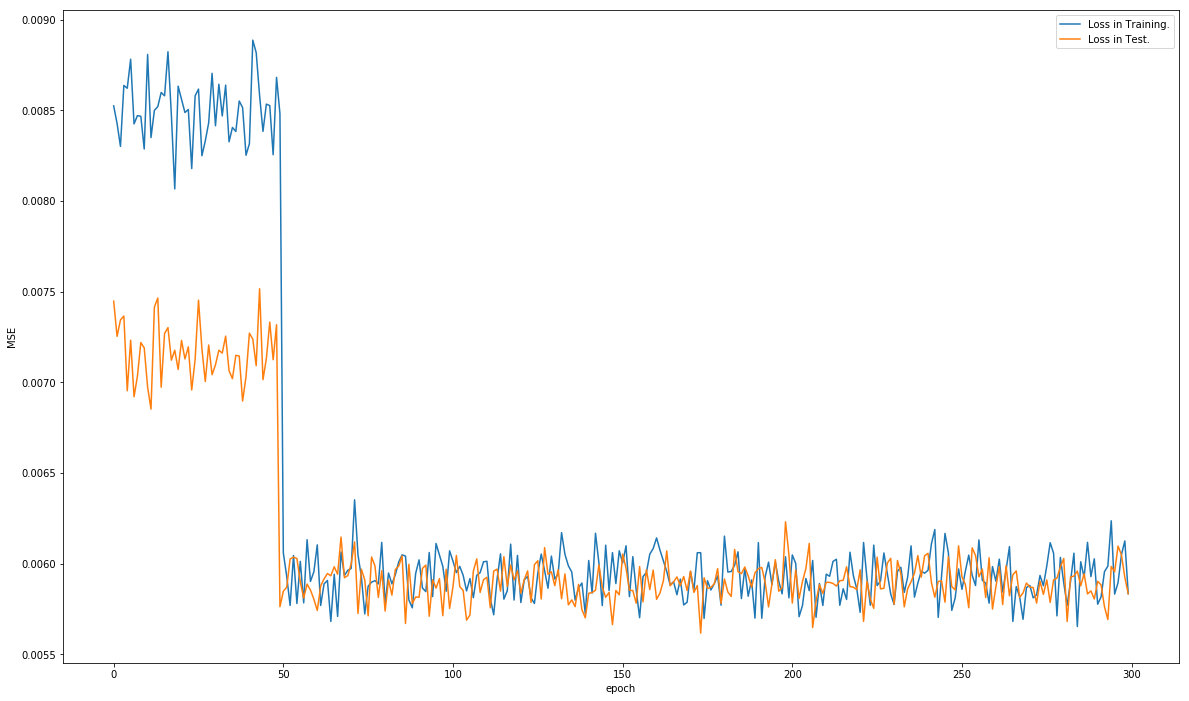

In [15]:
# Logging the loss.
fig = plt.figure(figsize=(20, 12))
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.train_loss.values, label="Loss in Training.")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.test_loss.values, label="Loss in Test.")
plt.legend()
plt.show();plt.close()

In [16]:
encoder_decoder_controller.verificatable_result.logs_df.tail(10)

,train_loss,test_loss
290,0.005776,0.005903
291,0.005817,0.005883
292,0.005956,0.005763
293,0.005987,0.005692
294,0.006237,0.005985
295,0.005832,0.005956
296,0.005896,0.006097
297,0.006049,0.006049
298,0.006125,0.005924
299,0.005834,0.005835


# References

- Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.
- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in Neural Information Processing Systems (pp. 5998-6008).